# Week 1 - Interpreting Image Classifiers📷

Welcome to the Week 1 project of the Interpreting Machine Learning Models course! We are excited to help you unravel the mysteries behind machine learning algorithms.

## Introduction - Week 1 Challenge💪

It's 2025 and the world is filled with self-driving cars🚘. Your company `Zuber` deploys uses these self-driving cars as robot taxis🚕. The software inside these cars use deep learning software to `detect` vehicles and navigate the car through the environment. Your team came with a new model that has better accuracy than previous models and they decide to roll-out the model next week.

<center><img src='https://media.tenor.com/khe_nqmAFJMAAAAC/driverless-car-veritasium.gif'></center>

 However, they want to make sure the algorithm can accurately identify caes and doesn't raise false alarms, especially while the owners are napping😉. To achieve this, they hire a machine learning expert(you, yes you) to interpret the deep learning model.

## We need you! 🫵

You are given a pre-trained ResNet model that is trained on Imagenet 1k dataset. Your task is to interpret "Why the ResNet model detects cars?"

For interpreting a classification task, there are multiple dimensions to choose from (Global vs Local, Model agnostic vs. specific, Inherent vs. post hoc). We will be using a Model agnostic post hoc method and deploy it at a local scale

Specifically, we will use LIME, SHAP, and integrated-gradient in this project. For each of these algorithms, you will be documenting the compute time and visualizing their explanations. At the end of the project, you'll be comparing the three evaluation approaches and assessing which you agree with most. So let's dive in!

## Setup 🛠️
Before we start our mission, lets gets some gear set up. Firstly, lets install the missing packages and import the necessary libraries.

Note: You may have to restart the runtime after installation

### Installation of Libraries

In [ ]:
!pip install omnixai
!pip install dash
!pip install dash-bootstrap-components
!pip install streamlit
## For local tunnel to a proxy server
!npm install localtunnel
!pip install jupyter-dash
!pip install ipython==7.34.0

### Imports

First, we will import some usual suspects. We will use Pillow Image library to laod/create images. Finally, let us import our main weapon. Let us use [OmniXAI](https://opensource.salesforce.com/OmniXAI/latest/index.html) (Omni eXplainable AI), a Python library for explainable AI (XAI).

In [1]:
## The usual suspects
import json
import numpy as np
import requests
import pickle

## To build our classifer
import torch
from torchvision import models, transforms

## Pillow Library Image function alias PilImage
from PIL import Image as PilImage

## Omnixai library to build our explainer
from omnixai.preprocessing.image import Resize
from omnixai.data.image import Image
from omnixai.explainers.vision import VisionExplainer
from omnixai.visualization.dashboard import Dashboard

## Streamllit for dashboard
import streamlit as st

#### NOTE: You may have to restart the run time because of ipython version conflict

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.10/dist-packages/dash/dash.py:525: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.



In [2]:
## Before we build our classifier, lets make sure to setup the device.
## To run this notbeook via GPU: Edit->Notebook settings ->Hardware accelerator -> GPU
## If your GPU is working, device is "cuda"
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Image Data and Classifier

In [3]:
## Let's start by loading the image that we want to explain
url = "http://images.cocodataset.org/val2017/000000084170.jpg"
url2 = "https://drive.google.com/uc?id=1V2yA16JxrPUZR_5qKNns1S5kZkUit7LB&export=download"
download = requests.get(url2, stream=True).raw

## TODO: Read the image using Pillow and convert the image into RBG
### Hint: Use PilImage to read and convert

image = Image(PilImage.open(download).convert('RGB'))

(1, 420, 640, 3)


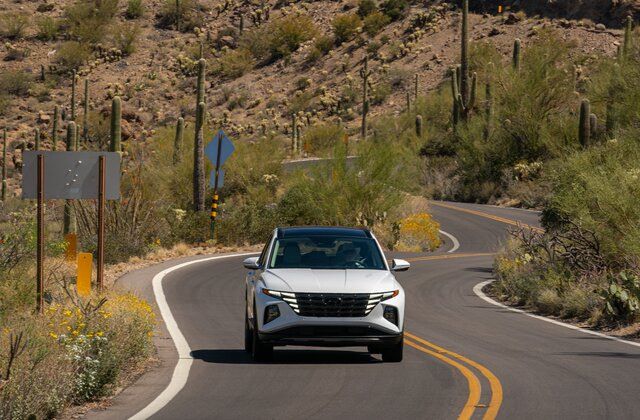

In [4]:
## TODO: Print the image shape and view the image

## Print the image shape
print(image.shape)

# Now, let's view it
image.to_pil()
# Shh! They are napping...

In [5]:
## TODO: Lets build our classification model. We will use pre-trained ResNet50 model from PyTorch torchvision models.
## Make sure to load the model onto the device for gpu

## NOTE: Use `resnet18` in case this is too big for the explainer

model = models.resnet34(weights = 'DEFAULT').to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 81.7MB/s]


In [6]:
# Lets get a summary of our model using torchsummary
from torchsummary import summary
## TODO: Print the model summary
### Hint: Use image shape for input_size
summary(model, input_size=(3,420,640))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 210, 320]           9,408
       BatchNorm2d-2         [-1, 64, 210, 320]             128
              ReLU-3         [-1, 64, 210, 320]               0
         MaxPool2d-4         [-1, 64, 105, 160]               0
            Conv2d-5         [-1, 64, 105, 160]          36,864
       BatchNorm2d-6         [-1, 64, 105, 160]             128
              ReLU-7         [-1, 64, 105, 160]               0
            Conv2d-8         [-1, 64, 105, 160]          36,864
       BatchNorm2d-9         [-1, 64, 105, 160]             128
             ReLU-10         [-1, 64, 105, 160]               0
       BasicBlock-11         [-1, 64, 105, 160]               0
           Conv2d-12         [-1, 64, 105, 160]          36,864
      BatchNorm2d-13         [-1, 64, 105, 160]             128
             ReLU-14         [-1, 64, 1

In [7]:
## Did you notice the last layer had 1000 classes. Lets import all the classes.
## We will later pass this to our explainer
classes_url = 'https://gist.githubusercontent.com/DaniFojo/dad37f5bf00ddeb56ed36daf561dbf69/raw/bd006b86300a5886ac7f897a44b0525b75a4b5a1/imagenet_labels.json'
imagenet_classes = json.loads(requests.get(classes_url).text)
idx2label =  {int(k):v for k,v in imagenet_classes.items()}

first_label = idx2label[next(iter(idx2label))]
print(f"The first class label from the ImageNet dataset is: '{first_label}'")

The first class label from the ImageNet dataset is: 'tench, Tinca tinca'


## Buiding our Explainer

To build our Explainer for our model, we will use [Vision Explainer](https://opensource.salesforce.com/OmniXAI/v1.2.3/omnixai.explainers.vision.html) by OmniXAI. The explainer needs some pre-processing and post-processing.

### Pre-processor

In [8]:
## TODO: Build the pre-processor pipeline for the explainer

# The preprocessing function should convert the image to a Tensor
# and then Normalise it

# 1. Compose the transformations
    ## 1a. write code to resize the image to 256
    ## 1b. write code to center crop 224
    ## 1c. write code to convert the image to tensor
    ## 1d. write code to normalize the image


mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [9]:
## TODO: Create the preprocess logic using the transformation built in previous cell
### Hint: Use torch.stack and load the images to the device

def preprocess(images):
  """
  Args:
    images: Sequence of images to preprocess using the composed
    transformations created above

  Returns:
    preprocessed_images: Sequence of preprocessed images
  """
  preprocessed_images = torch.stack([transform(im.to_pil()) for im in images]).to(device)
  return preprocessed_images


### Post-processor

Next, we need to define our post-processing function:

In [10]:
## TODO: Build the post-processor function for the explainer
# We will apply a softmax function to the logits obtained in the last layer
# in order to convert the prediction scores to probabilities

def postprocess(logits):
  """
  Args:
    logits: Logits from the last layer of the model

  Returns:
    postprocessed_outputs: Output from the Softmax layer applied to the logits
  """

  softmax = torch.nn.Softmax(dim=1)
  postprocessed_outputs = softmax(logits)

  return postprocessed_outputs

### Vision Explainer
Now, construct the explainer using the VisionExplainer class. You'll want to provide it a list of the three explainer types you'd like to try: LIME, SHAP, and integrated gradient. Be sure to check the documentation for the appropriate arguments! See the sample code for VisionExplainer [here](https://opensource.salesforce.com/OmniXAI/v1.2.3/tutorials/vision.html).

In [11]:
#TODO: Build the VisionExplainer by filling in the blanks
explainer = VisionExplainer(explainers=["lime", "shap", "ig"],
                            mode="classification",
                            model=model,
                            preprocess=preprocess,
                            postprocess=postprocess
                            )

Now, we can generate some explanations for each of the explainers using the explainer.explain() method. This may take couple of minutes on CPU.

In [12]:
## Time to generate the explanations
local_explanations = explainer.explain(Image(data=np.concatenate([image.to_numpy()]),batched=True))

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



In [13]:
## Lets write the local_explantions to a pickle file. We will use this in our dashboard
with open('file.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(local_explanations, file)

## Dashboard 🖼️
Now let's create a Dashboard to visualize our different explainers that we just built

In [14]:
# Launch a dashboard for visualization using streamlit or gradio

## TODO: Fill in the Dashboard parameters
dashboard = Dashboard(instances=Image(data=np.concatenate([image.to_numpy()]),batched=True),
                      local_explanations=local_explanations,
                      class_names=idx2label
                      )

dashboard.show(port=8000)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
### Alternatively, you can view the notebook on browser via the generated link below
### Google Colab hosts the server on remote local. Therefore, localhost on your machine will not lead you to the dashboard

#!nohup npx localtunnel --port 8000 > output.log &
#from google.colab.output import eval_js
#print(eval_js("google.colab.kernel.proxyPort(8000)"))

## If a link does not appear here, open `output.log` from files and use the link to get redirected.
## <NOTE> : It might take a minute for the log file to show up. Hit refresh if need be.

## Outro 🏃‍♂️

🎉Yay, you did it! Now that we've seen the explantions, you are ready to answer some questions about the various explanations!

1. What are your thoughts on Interpretable AI?
2. Compare the various explanations. Which method do you agree with most, why?
3. Do you think the ResNet model is good enough for your company's needs to detect cars?

## Bonus (Extension) 💰
Document the computation time for each explainer: LIME, SHAP, and integrated-gradient.

In [ ]:
## Lets use hugging face cats vs dogs dataset
!pip install datasets

In [16]:
## Now we will load 5 cat images from the dataset
from datasets import load_dataset

## Feel free to change this number. In order to not run out of RAM we use 5 images
NUM_IMAGES = 5
dataset = load_dataset("keremberke/license-plate-object-detection", 'mini')
cars_data = dataset['validation'][0:NUM_IMAGES]['image']
cars_data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=472x303>]

In [50]:
## Notice that the image sizes are different.
## TODO: Convert them to same size using transforms.Resize

transform_resize = transforms.Compose([transforms.Resize((256, 256))])

In [51]:
## Lets use the transformer and stack the images
# TODO: Use `transform_resize` and `np.stack`

cars = np.stack([transform_resize(car) for car in cars_data])

In [52]:
## We will use this explainer function to create independant explainer
def explainer(explainer):
  return VisionExplainer(
    explainers=[explainer],
    mode="classification",
    model=model,
    preprocess=preprocess,
    postprocess=postprocess,
  )

In [53]:
### TODO: Initialize the explainer for 'Lime', 'SHAP', and 'integrated gradient'
lime = explainer('lime')
shap = explainer('shap')
ig = explainer('ig')

In [54]:
## Let us time the results. We will use built-in magic commands in jupyter
%time lime_results = lime.explain(cars)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 26.4 s, sys: 409 ms, total: 26.8 s
Wall time: 28 s


In [55]:
%time shap_results = shap.explain(cars)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning:

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.



CPU times: user 1min 33s, sys: 1.82 s, total: 1min 35s
Wall time: 1min 40s


In [56]:
%time ig_results = ig.explain(cars)

CPU times: user 6.5 s, sys: 40.6 ms, total: 6.54 s
Wall time: 6.57 s


In [59]:
### Google Colab hosts the server on remote local. Therefore, localhost on your machine will not lead you to the dashboard

## Open `output.log` from files and use the link to get redirected.
## <NOTE> : It might take a minute for the log file to show up. Hit refresh if need be.
!nohup npx localtunnel --port 8000 > output.log &

nohup: redirecting stderr to stdout


In [ ]:
## Combine all results
combine_results = lime_results
combine_results['shap'] = shap_results['shap']
combine_results['ig'] = ig_results['ig']

## Lets visualize the results on the Dashboard
dashboard = Dashboard(
    instances=Image(cars,batched =True),
    local_explanations=combine_results,
    class_names=idx2label
)
## Do not change the port
## <NOTE> Once you open the link, it might take a minute or two for the website to load fully. Be patient :)
dashboard.show(port=8000)

In [ ]:
#Get the ip adress to view the dashboard on the link
!wget -q -O - ipv4.icanhazip.com

## Final Thoughts🎉

Congratulations on finishing the bonus sections. It is an impressive feat!

---
Please share your observations about the computation time for each of the explainers and recommend a method based on this and any other relevant factors, such as effectiveness or accuracy? If your recommendation differs from a previous suggestion, please explain the reason for this change.